In [1]:
#non volume preserving normalising flow
#we use gaussian mixture model for this however.

from sklearn.covariance import log_likelihood
from torch import distributions
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
os.chdir('../Data_handling')
from gmm_torch import GaussianMixture
from gmmflow import TorchGaussMixture
os.chdir('../Practice')
# I will need to do batch normalisation


Mask tensor

In [2]:

class FlowGMM(nn.Module):
    def __init__(self,layers,n_features,mixture_components,hidden_dims,d,means):
        super().__init__()
        self.layers=layers
        self.b1=torch.tensor([i for i in range(1,n_features+1)],requires_grad=False).le(n_features-d)
        self.b2=torch.tensor([i for i in range(1,n_features+1)],requires_grad=False).ge(d+1)
        self.D=n_features
        self.d=d
        self.prior=TorchGaussMixture(means=means)
        #self.prior=GaussianMixture(n_components=mixture_components,n_features=self.D,init_params='random')

        self.s_net=nn.ModuleList([nn.Sequential(
            nn.Linear(self.d,hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0],hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1],(self.D-self.d)) #d is the dimension of 1:d vector, 
                            ) for i in range(layers)])
        self.t_net=nn.ModuleList([nn.Sequential(
            nn.Linear(self.d,hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0],hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1],(self.D-self.d)) #d is the dimension of 1:d vector, 
                            ) for i in range(layers)])
    
    
    def forward(self,x):
        loss=0.0
        det_s=0
        for i in range(self.layers):
            #paper recommends doing batch normalisation at each layer
            n=nn.BatchNorm1d(self.D)
            x=n(x)
            #####################################################
            #Switch the mask at each layer.
            if(i%2==0):
                b=self.b1
            else:
                b=self.b2
            
            x1d=x[:,b.nonzero()[:,0]]
            xdD=x[:,~b.nonzero()[:,0]]
            
            #####################################################
            # Coupling layer

            y1d=x1d

            s,t=self.s_net[i](x1d),self.t_net[i](x1d)
            ydD=xdD*torch.exp(s)+t
            
            #######
            # Determinant of the transformation is sum of s terms

            det_s+=s.sum(-1).mean() #each row is component of s, thats summed then summed over each value due to independence?
            x=torch.cat([y1d,ydD],-1) #loop through to the next layer
        
        y=x
        #########################################
        #loss log likelihood part
        ###
        #Fit GMM to image of f(x)
        
        gmm=self.prior
        #gmm.fit(y)
        

        log_likelihood=gmm.log_prob(y).mean()#gmm.score_samples(y).sum()
        ## Loss is negative log likelihood
        loss=-1*(det_s+log_likelihood)
        
        return y, gmm, loss, log_likelihood,det_s





In [3]:
n_samples = 10000
batch_size=1000
# Increase or decrease this if you wish.
r = 5.0
means = torch.tensor([[-r, -r], [r, r]])

from torch.utils.data import DataLoader
# Define distribution. 
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X= noisy_moons[0]
X = StandardScaler().fit_transform(X)
X=DataLoader(torch.tensor(X).float(),batch_size=batch_size) 
model = FlowGMM(layers=3,n_features=noisy_moons[0].shape[-1],mixture_components=2,hidden_dims=[50,50],d=1,means=means)

# Training hyperparameters.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



In [4]:


epochs=100
# Initialise the minimum loss at infinity.
min_loss = float('inf')
plot_loss=[]
plotll=[]
plotdet=[]
# Iterate over the number of iterations.
model.train()

for epoch in range(epochs):    
        overall_loss = 0
        for batch_idx, x in enumerate(X):

            x = x.view(batch_size, len(x[0]))
            #x = x.to(DEVICE)

            optimizer.zero_grad()

            y,gmm,loss,ll,det = model(x)

            
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
        plot_loss.append(loss)   
        plotll.append(ll)  
        plotdet.append(det)   
        print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
        print("Overall Loss: ", overall_loss)
    
print("Finish!!")





/Users/mattocallaghan/GES/Data_handling/gmmflow.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mixture_log_probs = torch.logsumexp(all_log_probs + torch.log(F.softmax(self.weights)), dim=1)


	Epoch 1 complete! 	Average Loss:  0.026132715225219726
Overall Loss:  235.19443702697754
	Epoch 2 complete! 	Average Loss:  0.02565040440029568
Overall Loss:  230.85363960266113
	Epoch 3 complete! 	Average Loss:  0.025180632061428496
Overall Loss:  226.62568855285645
	Epoch 4 complete! 	Average Loss:  0.024714665730794273
Overall Loss:  222.43199157714844
	Epoch 5 complete! 	Average Loss:  0.024245576434665256
Overall Loss:  218.2101879119873
	Epoch 6 complete! 	Average Loss:  0.023766295962863497
Overall Loss:  213.89666366577148
	Epoch 7 complete! 	Average Loss:  0.02327272457546658
Overall Loss:  209.45452117919922
	Epoch 8 complete! 	Average Loss:  0.022762197494506836
Overall Loss:  204.85977745056152
	Epoch 9 complete! 	Average Loss:  0.022232286241319444
Overall Loss:  200.090576171875
	Epoch 10 complete! 	Average Loss:  0.021676917817857532
Overall Loss:  195.09226036071777
	Epoch 11 complete! 	Average Loss:  0.021085053973727758
Overall Loss:  189.7654857635498
	Epoch 12 comp

KeyboardInterrupt: 

In [ ]:
model.eval()

FlowGMM(
  (s_net): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=1, bias=True)
    )
    (1): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=1, bias=True)
    )
    (2): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=1, bias=True)
    )
  )
  (t_net): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in

In [ ]:
for i in range(len(plot_loss)):
    plot_loss[i]=plot_loss[i].detach().numpy()
    plotll[i]=plotll[i].detach().numpy()
    plotdet[i]=plotdet[i].detach().numpy()

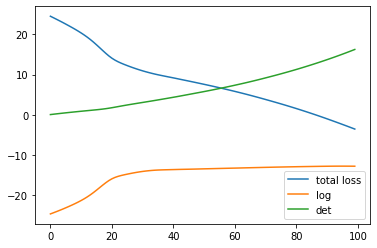

In [ ]:
import matplotlib.pyplot as plt
plt.plot(plot_loss,label='total loss')
plt.plot(plotll, label='log')
plt.plot(plotdet,label='det')
plt.legend()


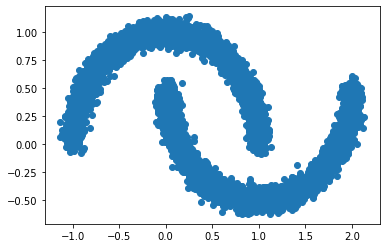

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(noisy_moons[0].transpose()[0],noisy_moons[0].transpose()[1])

In [ ]:
torch.tensor(noisy_moons[0])

tensor([[-0.3075,  0.9170],
        [-0.2208,  0.9018],
        [ 1.9302,  0.2363],
        ...,
        [-0.2287,  0.9877],
        [-0.2305,  1.0466],
        [ 0.1492,  0.9931]], dtype=torch.float64)

In [ ]:
x= torch.tensor(noisy_moons[0])
y,gmm,loss,_,_=model(x.float())

/Users/mattocallaghan/GES/Data_handling/gmmflow.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mixture_log_probs = torch.logsumexp(all_log_probs + torch.log(F.softmax(self.weights)), dim=1)


In [ ]:
probs=gmm.class_probs(y)

/Users/mattocallaghan/GES/Data_handling/gmmflow.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  log_probs_weighted = log_probs + torch.log(F.softmax(self.weights))


(array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]),
 array([4.164929e-25, 1.000000e-01, 2.000000e-01, 3.000000e-01,
        4.000000e-01, 5.000000e-01, 6.000000e-01, 7.000000e-01,
        8.000000e-01, 9.000000e-01, 1.000000e+00], dtype=float32),
 <a list of 2 BarContainer objects>)

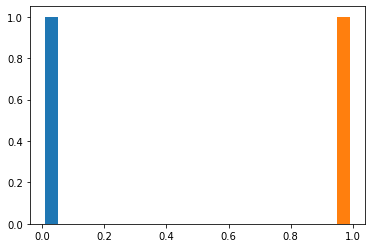

In [ ]:
plt.hist(probs[0].detach())

In [ ]:
probs.detach().numpy().transpose()[0,np.newaxis]

array([[4.1649292e-25, 3.1187367e-23, 1.4849184e-36, ..., 1.6823278e-25,
        1.4077027e-26, 7.0188577e-23]], dtype=float32)

In [ ]:
probs.detach().numpy().transpose()[0].shape

(10000,)

In [ ]:
import pandas as pd
noisy_moons=x.detach().numpy()
probs.detach().numpy().transpose()[0]
final=np.concatenate((noisy_moons,probs.detach().numpy(),y.detach().numpy()),axis=-1)

In [ ]:
plot_df=pd.DataFrame(data=final,columns=['x','y','p1','p2','y1','y2'])

<AxesSubplot:xlabel='x', ylabel='y'>

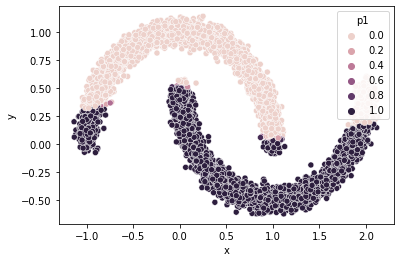

In [ ]:
import seaborn as sns
sns.scatterplot(data=plot_df,x='x',y='y',hue='p1')

<AxesSubplot:xlabel='y1', ylabel='y2'>

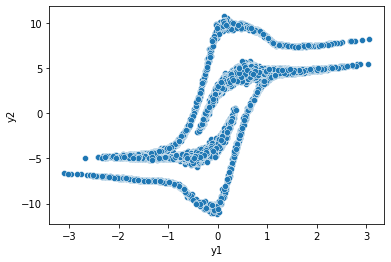

In [ ]:
sns.scatterplot(data=plot_df,x='y1',y='y2')

In [ ]:
x=TorchGaussMixture(means=means)

In [ ]:
plot=x.sample_n(10000).detach().numpy()

/Users/mattocallaghan/miniforge3/envs/astro/lib/python3.8/site-packages/torch/distributions/distribution.py:161: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
/Users/mattocallaghan/GES/Data_handling/gmmflow.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  idx = np.random.choice(self.n_components, size=(n_samples, 1), p=F.softmax(self.weights))


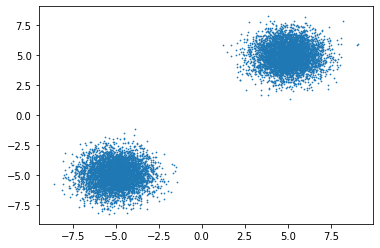

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(plot.transpose()[0],plot.transpose()[1],s=0.5)